# Open Earth Foundation
## Open Ocean

This is the second of a series of 4 notebooks that explains step by step how to calculate each metric used to calculate each modulating factor for the Marine Biodiversity Units applied to the Cocos Marine Conservation Area of Costa Rica

## Libraries

In [8]:
#!pip install pyobis

In [1]:
import os
import glob
import boto3

import math
import numpy as np
import pandas as pd
from pyobis import occurrences

import matplotlib.pyplot as plt

import shapely
import geopandas as gpd
from shapely.geometry import Polygon, Point, box
from shapely.ops import linemerge, unary_union, polygonize

In [2]:
import fiona; #help(fiona.open)

In [29]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
#Run this to reload the python file
%autoreload 2
from MBU_utils import *

# Data

Two data sources are used for these calculations, data from OBIS (observation points) and those from the IUCN red list (distribution polygons).

- Indices such as Shannon and Simpson can be calculated only with OBIS data
- Metrics like WEGE and Endemism can be calculated only with IUCN data
- Habitats accounting is calculating with IUCN Global Ecosystem Typology

**Accessing OBIS data**

OBIS data contains species information and points of observation

In [5]:
# MPA file
ACMC = gpd.read_file('https://ocean-program.s3.amazonaws.com/data/raw/MPAs/ACMC.geojson')

In [6]:
#create a polygon to access the OBIS data
min_x, min_y, max_x, max_y = ACMC.total_bounds
geometry = f"POLYGON(({max_x} {min_y}, {min_x} {min_y}, {min_x} {max_y}, {max_x} {max_y}, {max_x} {min_y}))"

query = occurrences.search(geometry=geometry)
query.execute()

# Returns the data
df2 = query.data 

4235 to be fetched. Estimated time =  0.5348432445526123  11  seconds
Fetching: [████████████████████████████████████████████████████████████████████████████████████████████████████] 4235/4235
Fetched 4235 records.


In [7]:
# convert OBIS dataframe to geodataframe
# making point with the lat and lon information
df2 = gpd.GeoDataFrame(df2, geometry=gpd.points_from_xy(df2.decimalLongitude, df2.decimalLatitude))

**Accesing IUCN RedList data**

In [8]:
#df1 = gpd.read_file('s3://ocean-program/data/processed/ACMC_IUCN_RedList/gdf_ACMC_IUCN_range_status_filtered.shp')
df1 = gpd.read_file('s3://ocean-program/data/Test/gdf_range_status_filtered_shortV.shp')

**Accesing IUCN Global Ecosystem Typology**

For this step, it's needed only the ubication path of these files

In [9]:
#From AWS
s3 = boto3.resource('s3')
bucket = s3.Bucket('ocean-program')

eco_names = []

for obj in bucket.objects.filter(Prefix='data/raw/Ecosystems/'):
    name = obj.key[:]
    eco_names.append(f'https://ocean-program.s3.amazonaws.com/{name}')

# Metrics and Indices

First, we need to build a grid geoDataFrame

In [38]:
# Making a grid geoDataFrame
grid = create_grid(ACMC, grid_shape="hexagon", grid_size_deg=0.05)

## Using OBIS data

`Note`: Endemism and WEGE indices are not available for this data set

**Shannon Index**

In [31]:
Shannon = shannon(ACMC, df2, grid)

/Users/maureenfonseca/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3369: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/maureenfonseca/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [32]:
Shannon.head()

,Grid_ID,basisOfRecord,decimalLatitude,decimalLongitude,scientificName,scientificNameID,id,dataset_id,node_id,dropped,...,wege_x,habitat_accounting_x,N,pi,shannon,geometry,species_richness_y,endemism_y,wege_y,habitat_accounting_y
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,"POLYGON ((-89.27201 2.15063, -89.29701 2.19394...",1,NaN,NaN,NaN
1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,"POLYGON ((-89.27201 2.23724, -89.29701 2.28054...",1,NaN,NaN,NaN
2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,"POLYGON ((-89.27201 2.32384, -89.29701 2.36714...",1,NaN,NaN,NaN
3,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,"POLYGON ((-89.27201 2.41044, -89.29701 2.45374...",1,NaN,NaN,NaN
4,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,"POLYGON ((-89.27201 2.49704, -89.29701 2.54035...",1,NaN,NaN,NaN


Text(0.5, 1.0, 'Shannon Index for ACMC\nSource: OBIS')

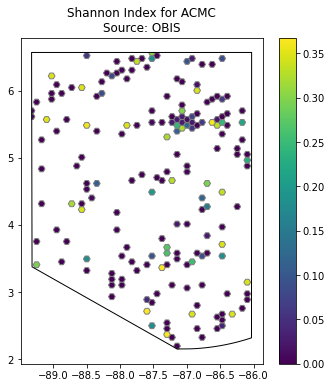

In [33]:
Shannon = gpd.clip(Shannon.set_crs(epsg=4326, allow_override=True), ACMC.set_crs(epsg=4326, allow_override=True))
ax = Shannon.plot(column='shannon', figsize=(6, 6), cmap='viridis', edgecolor="grey", legend = True)

gpd.GeoSeries(ACMC.geometry).plot(ax=ax, edgecolor='black', facecolor='none', label='ACMC')
plt.title('Shannon Index for ACMC\nSource: OBIS')

**Simpson Index**

In [34]:
Simpson = simpson(ACMC, df2, grid)

In [35]:
Simpson.head()

,Grid_ID,simpson,geometry,species_richness,endemism,wege,habitat_accounting
0,0,NaN,"POLYGON ((-89.27201 2.15063, -89.29701 2.19394...",1,NaN,NaN,NaN
1,1,NaN,"POLYGON ((-89.27201 2.23724, -89.29701 2.28054...",1,NaN,NaN,NaN
2,2,NaN,"POLYGON ((-89.27201 2.32384, -89.29701 2.36714...",1,NaN,NaN,NaN
3,3,NaN,"POLYGON ((-89.27201 2.41044, -89.29701 2.45374...",1,NaN,NaN,NaN
4,4,NaN,"POLYGON ((-89.27201 2.49704, -89.29701 2.54035...",1,NaN,NaN,NaN


Text(0.5, 1.0, 'Simpson Index for ACMC\nSource: OBIS')

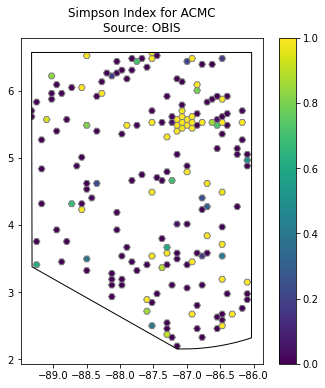

In [36]:
Simpson = gpd.clip(Simpson.set_crs(epsg=4326, allow_override=True), ACMC.set_crs(epsg=4326, allow_override=True))
ax = Simpson.plot(column='simpson', figsize=(6, 6), cmap='viridis', edgecolor="grey", legend = True)

gpd.GeoSeries(ACMC.geometry).plot(ax=ax, edgecolor='black', facecolor='none', label='ACMC')
plt.title('Simpson Index for ACMC\nSource: OBIS')

**Species Richness**

In [17]:
Species_Richness = species_richness(ACMC, df2, grid)

In [18]:
Species_Richness.head()

,geometry,Grid_ID,species_richness
0,"POLYGON ((-89.27201 2.15063, -89.29701 2.19394...",0,1
1,"POLYGON ((-89.27201 2.23724, -89.29701 2.28054...",1,1
2,"POLYGON ((-89.27201 2.32384, -89.29701 2.36714...",2,1
3,"POLYGON ((-89.27201 2.41044, -89.29701 2.45374...",3,1
4,"POLYGON ((-89.27201 2.49704, -89.29701 2.54035...",4,1


Text(0.5, 1.0, 'Species Richness metric for ACMC\nSource: OBIS')

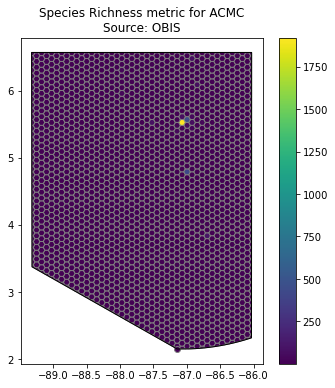

In [19]:
Species_Richness = gpd.clip(Species_Richness.set_crs(epsg=4326, allow_override=True), ACMC.set_crs(epsg=4326, allow_override=True))
ax = Species_Richness.plot(column='species_richness', figsize=(6, 6), cmap='viridis', edgecolor="grey", legend = True)

gpd.GeoSeries(ACMC.geometry).plot(ax=ax, edgecolor='black', facecolor='none', label='ACMC')
plt.title('Species Richness metric for ACMC\nSource: OBIS')

## Using IUCN data

`Note`: Shannon and Simpson indices are not available for this data set

**Species Richness**

In [39]:
Species_Richness = species_richness(ACMC, df1, grid)

/Users/maureenfonseca/Documents/OEF/oceanprogram/Marine_Ecosystem_Credits/Marine_Biodiversity/MBU_Methodology/MBU_utils.py:143: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if this_row_boundary.type[:len('multi')].lower() == 'multi':
/Users/maureenfonseca/Documents/OEF/oceanprogram/Marine_Ecosystem_Credits/Marine_Biodiversity/MBU_Methodology/MBU_utils.py:164: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  new_gdf['geom_centroid'] = new_gdf.centroid


In [40]:
Species_Richness.head()

,geometry,Grid_ID,species_richness
0,"POLYGON ((-89.27201 2.15063, -89.29701 2.19394...",0,NaN
1,"POLYGON ((-89.27201 2.23724, -89.29701 2.28054...",1,NaN
2,"POLYGON ((-89.27201 2.32384, -89.29701 2.36714...",2,NaN
3,"POLYGON ((-89.27201 2.41044, -89.29701 2.45374...",3,NaN
4,"POLYGON ((-89.27201 2.49704, -89.29701 2.54035...",4,NaN


Text(0.5, 1.0, 'Species Richness metric for ACMC\nSource: IUCN')

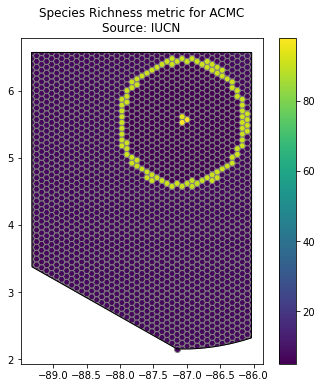

In [41]:
Species_Richness = gpd.clip(Species_Richness.set_crs(epsg=4326, allow_override=True), ACMC.set_crs(epsg=4326, allow_override=True))
ax = Species_Richness.plot(column='species_richness', figsize=(6, 6), cmap='viridis', edgecolor="grey", legend = True)

gpd.GeoSeries(ACMC.geometry).plot(ax=ax, edgecolor='black', facecolor='none', label='ACMC')
plt.title('Species Richness metric for ACMC\nSource: IUCN')

**Endemism**

In [20]:
Endemism = endemism(ACMC, df1, grid)

/Users/maureenfonseca/Documents/OEF/oceanprogram/Marine_Ecosystem_Credits/Marine_Biodiversity/MBU_Methodology/MBU_utils.py:483: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  dist_ratio2 = np.round(df2.area/gdf.area, decimals=4, out=None)
/Users/maureenfonseca/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/maureenfonseca/Documents/OEF/oceanprogram/Marine_Ecosystem_Credits/Marine_Biodiversity/MBU_Methodology/MBU_utils.py:200: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  new_gdf = gdf.explode('geometry')


In [21]:
Endemism.head()

,geometry,Grid_ID,species_richness,endemism
0,"POLYGON ((-89.27201 2.15063, -89.29701 2.19394...",0,1,NaN
1,"POLYGON ((-89.27201 2.23724, -89.29701 2.28054...",1,1,NaN
2,"POLYGON ((-89.27201 2.32384, -89.29701 2.36714...",2,1,NaN
3,"POLYGON ((-89.27201 2.41044, -89.29701 2.45374...",3,1,NaN
4,"POLYGON ((-89.27201 2.49704, -89.29701 2.54035...",4,1,NaN


Text(0.5, 1.0, 'Endemism metric for ACMC\nSource: IUCN')

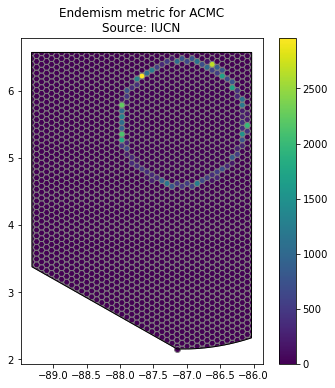

In [22]:
Endemism = gpd.clip(Endemism.set_crs(epsg=4326, allow_override=True), ACMC.set_crs(epsg=4326, allow_override=True))
ax = Endemism.plot(column='endemism', figsize=(6, 6), cmap='viridis', edgecolor="grey", legend = True)

gpd.GeoSeries(ACMC.geometry).plot(ax=ax, edgecolor='black', facecolor='none', label='ACMC')
plt.title('Endemism metric for ACMC\nSource: IUCN')

**WEGE Index**

In [23]:
Wege = wege(ACMC, df1, grid)

/Users/maureenfonseca/Documents/OEF/oceanprogram/Marine_Ecosystem_Credits/Marine_Biodiversity/MBU_Methodology/MBU_utils.py:576: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  MPA_area = MPA.area[0]
/Users/maureenfonseca/Documents/OEF/oceanprogram/Marine_Ecosystem_Credits/Marine_Biodiversity/MBU_Methodology/MBU_utils.py:583: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  we = np.round(df.area/MPA_area, decimals=4, out=None)
/Users/maureenfonseca/Documents/OEF/oceanprogram/Marine_Ecosystem_Credits/Marine_Biodiversity/MBU_Methodology/MBU_utils.py:200: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current 

In [24]:
Wege.head()

,geometry,Grid_ID,species_richness,endemism,wege
0,"POLYGON ((-89.27201 2.15063, -89.29701 2.19394...",0,1,NaN,NaN
1,"POLYGON ((-89.27201 2.23724, -89.29701 2.28054...",1,1,NaN,NaN
2,"POLYGON ((-89.27201 2.32384, -89.29701 2.36714...",2,1,NaN,NaN
3,"POLYGON ((-89.27201 2.41044, -89.29701 2.45374...",3,1,NaN,NaN
4,"POLYGON ((-89.27201 2.49704, -89.29701 2.54035...",4,1,NaN,NaN


Text(0.5, 1.0, 'Wege index for ACMC\nSource: IUCN')

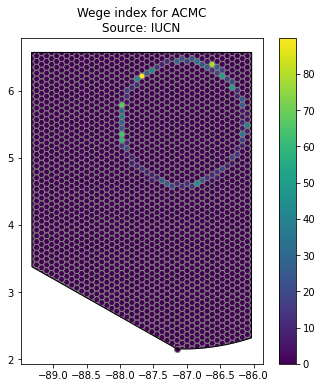

In [25]:
Wege = gpd.clip(Wege.set_crs(epsg=4326, allow_override=True), ACMC.set_crs(epsg=4326, allow_override=True))
ax = Wege.plot(column='wege', figsize=(6, 6), cmap='viridis', edgecolor="grey", legend = True)

gpd.GeoSeries(ACMC.geometry).plot(ax=ax, edgecolor='black', facecolor='none', label='ACMC')
plt.title('Wege index for ACMC\nSource: IUCN')

**Habitats Accounting**

In [26]:
Habitat_accounting = habitat_accounting(ACMC, grid, eco_names)

/Users/maureenfonseca/Documents/OEF/oceanprogram/Marine_Ecosystem_Credits/Marine_Biodiversity/MBU_Methodology/MBU_utils.py:143: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if this_row_boundary.type[:len('multi')].lower() == 'multi':
/Users/maureenfonseca/Documents/OEF/oceanprogram/Marine_Ecosystem_Credits/Marine_Biodiversity/MBU_Methodology/MBU_utils.py:164: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  new_gdf['geom_centroid'] = new_gdf.centroid


In [27]:
Habitat_accounting.head()

,geometry,Grid_ID,species_richness,endemism,wege,habitat_accounting
0,"POLYGON ((-89.27201 2.15063, -89.29701 2.19394...",0,1,NaN,NaN,NaN
1,"POLYGON ((-89.27201 2.23724, -89.29701 2.28054...",1,1,NaN,NaN,NaN
2,"POLYGON ((-89.27201 2.32384, -89.29701 2.36714...",2,1,NaN,NaN,NaN
3,"POLYGON ((-89.27201 2.41044, -89.29701 2.45374...",3,1,NaN,NaN,NaN
4,"POLYGON ((-89.27201 2.49704, -89.29701 2.54035...",4,1,NaN,NaN,NaN


Text(0.5, 1.0, 'Habitat_accounting for ACMC\nSource: IUCN')

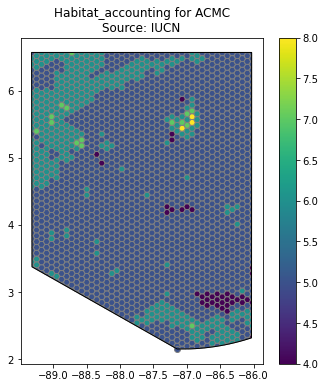

In [28]:
Habitat_accounting = gpd.clip(Habitat_accounting.set_crs(epsg=4326, allow_override=True), ACMC.set_crs(epsg=4326, allow_override=True))
ax = Habitat_accounting.plot(column='habitat_accounting', figsize=(6, 6), cmap='viridis', edgecolor="grey", legend = True)

gpd.GeoSeries(ACMC.geometry).plot(ax=ax, edgecolor='black', facecolor='none', label='ACMC')
plt.title('Habitat_accounting for ACMC\nSource: IUCN')